In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

import pathlib

In [4]:
# bs = 64
bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

In [5]:
path = pathlib.Path('./justice_league')
path.ls()

[PosixPath('justice_league/images'), PosixPath('justice_league/labels.txt')]

In [6]:
path_img = path/'images'

In [7]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('justice_league/images/Robin: Robin #117 Direct Sales (2003-08-20).jpg'),
 PosixPath('justice_league/images/The Flash: The Flash #105 Original (1958-12-23).jpg'),
 PosixPath('justice_league/images/Batman: Batman #659 Direct Sales (2006-11-29).jpg'),
 PosixPath('justice_league/images/Detective Comics: Detective Comics #455 Original (1975-10-28).jpg'),
 PosixPath('justice_league/images/The Flash: The Flash #46 Looney Tunes Variant Cover (2015-11-25).jpg')]

In [8]:
base_ratio = 120
"{} x {}".format(base_ratio * (600 / 400), base_ratio)

'180.0 x 120'

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

data = ImageDataBunch.from_csv(path=path, 
                               folder="images",
                               csv_labels="labels.txt",
                               fn_col=0,
                               label_col=1,
                               delimiter="\t",
                               label_delim="|",
                               valid_pct=0.2,
                               size=(180, 120))
data

ImageDataBunch;

Train: LabelList (13167 items)
x: ImageList
Image (3, 180, 120),Image (3, 180, 120),Image (3, 180, 120),Image (3, 180, 120),Image (3, 180, 120)
y: MultiCategoryList
Robin,Flash;Dr. Mid-Nite;Wildcat,Batman,Wonder Woman;Hawkman,Zatanna
Path: justice_league;

Valid: LabelList (3291 items)
x: ImageList
Image (3, 180, 120),Image (3, 180, 120),Image (3, 180, 120),Image (3, 180, 120),Image (3, 180, 120)
y: MultiCategoryList
Captain Cold,Nightwing,Batman;Robin,Robin;Kid Flash,Green Lantern
Path: justice_league;

Test: None

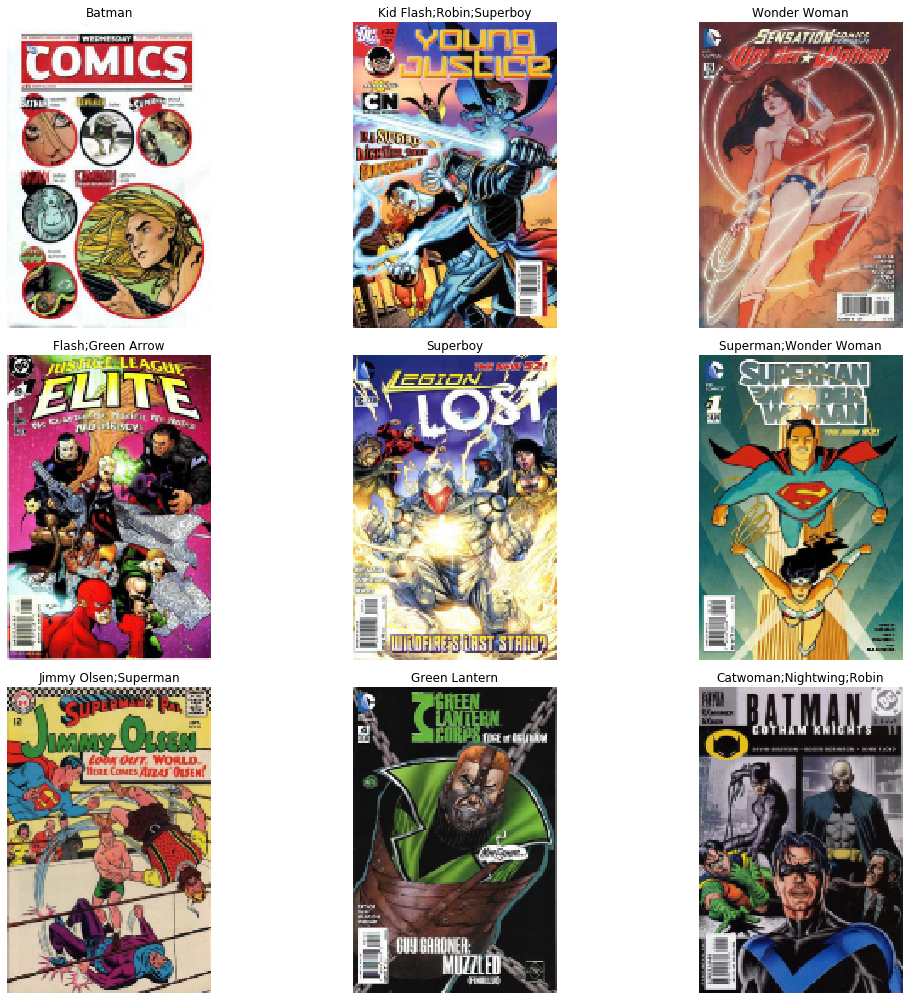

In [12]:
data.show_batch(rows=3, figsize=(16, 14))

In [13]:
print(data.classes)
len(data.classes),data.c

['Aqualad', 'Aquaman', 'Atom', 'Batgirl', 'Batman', 'Beast Boy', 'Black Canary', 'Brainiac', 'Captain Cold', 'Catwoman', 'Changeling', 'Cyborg', 'Dr. Fate', 'Dr. Mid-Nite', 'Elongated Man', 'Flash', 'Green Arrow', 'Green Lantern', 'Hawkgirl', 'Hawkman', 'Jericho', 'Jimmy Olsen', 'Joker', 'Katana', 'Kid Flash', 'Lex Luthor', 'Lois Lane', 'Martian Manhunter', 'Mera', 'Nightwing', 'Penguin', 'Perry White', 'Power Girl', 'Raven', 'Robin', 'Scarecrow', 'Starfire', 'Stargirl', 'Steve Trevor', 'Superboy', 'Supergirl', 'Superman', 'Terra', 'The Atom', 'The Flash', 'Two-Face', 'Wildcat', 'Wonder Girl', 'Wonder Woman', 'Zatanna']


(50, 50)

Deep Learning Experiments

1. Resnet 34 (train a comic book specific resnet model)
2. Language Model (create a language model that writes comic book synopses)
3. Style Transfer (create style filters and apply them to covers)
4. Character / Object Detection (detect characters on a cover)
5. GAN ("dream" comic book covers)
6. Joint Probability Synopsis/Cover (given a synopsis, generate a comic book cover)

In [ ]:
arch = models.resnet50

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score])

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = (1e-2 + 1e-1) / 2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save("justice-league-stage-1-rn50")

In [ ]:
learn.recorder.plot_losses()

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(5, slice(1e-3, lr/5))

In [ ]:
learn.save('justice-league-stage-2-rn50')